In [1]:
import numpy as np
from scipy.integrate import solve_bvp
from matplotlib import pyplot as plt

from matplotlib import animation
import matplotlib as mpl

In [2]:

# ----- WARNING SUPPRESSION -----
# This should not be used lightly. This is primarily for formatting reasons for our paper.
import warnings
warnings.filterwarnings('ignore')

DEFAULT_FIGSIZE = (5, 5)
plt.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
plt.rcParams.update({'font.size': 6})

mpl.rcParams["figure.dpi"] = 300

# ---- ENABLE LATEX MATPLOTLIB FONT -----
# Don't run this cell if you have issues with your latex installation
# Use LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman"
})

plt.style.use("seaborn-v0_8-muted")

In [3]:
# On arakis, so elliptical orbits
# Ellipse is a parametric of t
def ellipse(t: np.ndarray, A: float=1, B: float=1) -> np.ndarray:
    """Get ellipse over time.

    Args:
        t (np.ndarray): The timeseries of timesteps.
        A (float, optional): X axis stretch factor. Defaults to 1.
        B (float, optional): Y axis stretch factor. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    return np.array([A * np.cos(t), B * np.sin(t)])

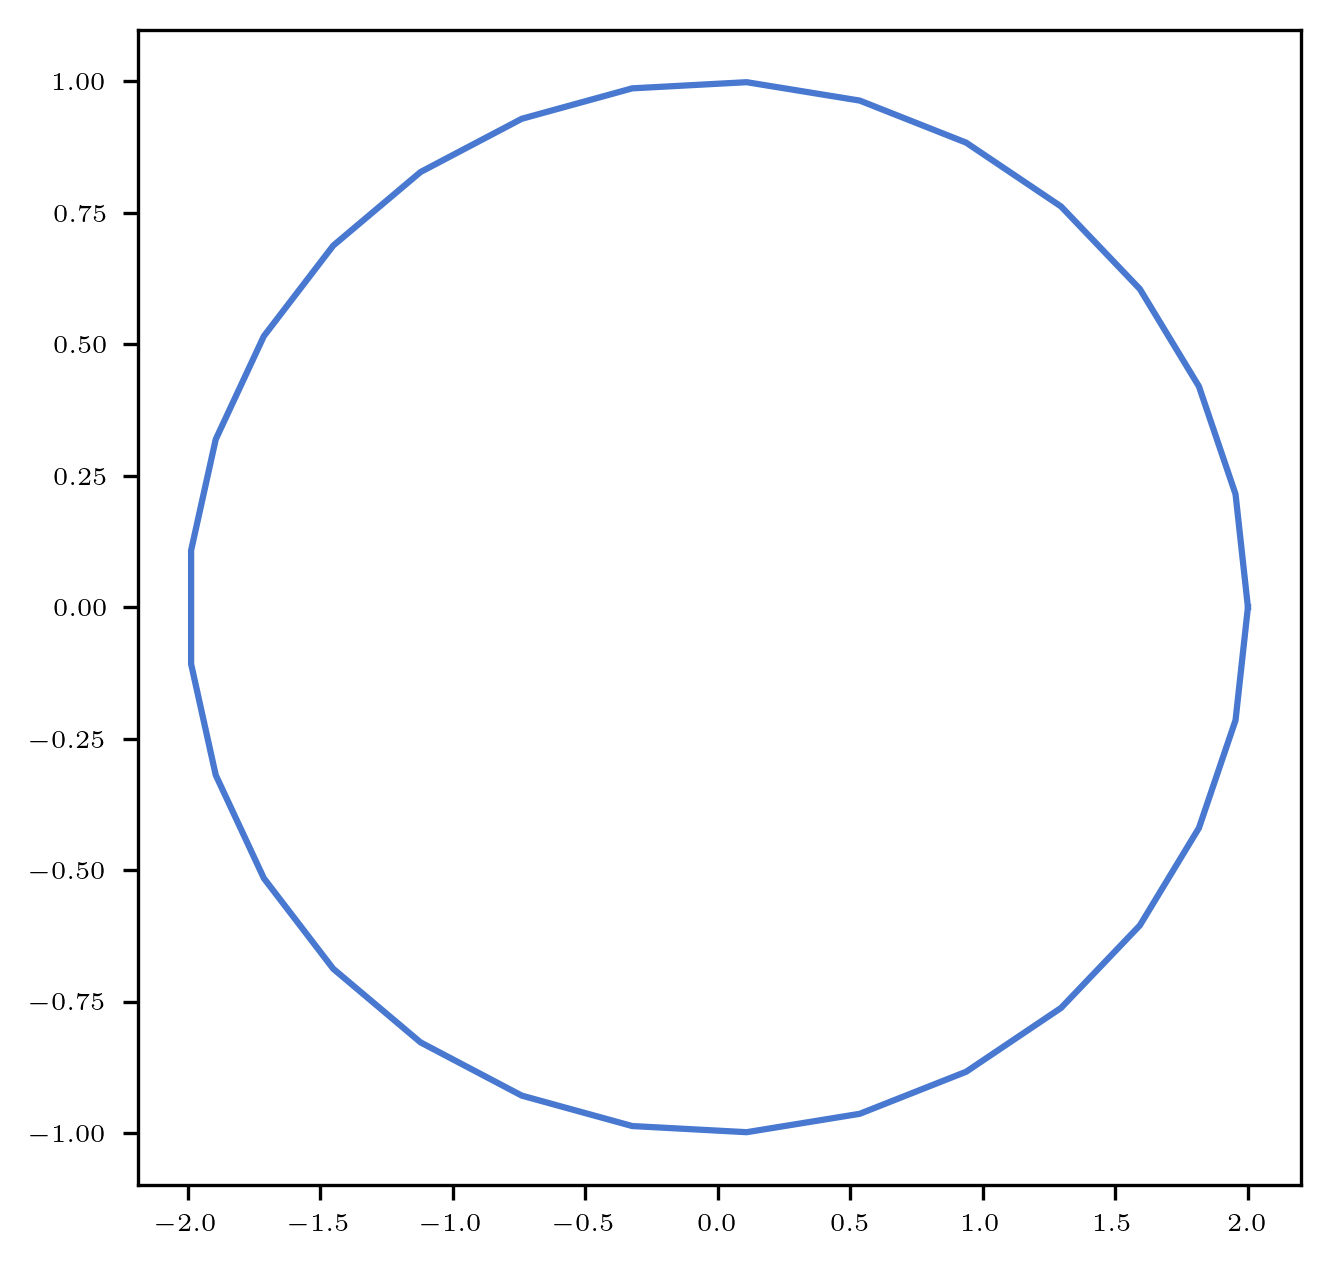

In [4]:
e = ellipse(np.linspace(0, 2*np.pi, 30), 2, 1)
plt.plot(e[0,:], e[1,:])

$F = m_{ss} * [m_other/(dist to other ** 2)]$

In [5]:
# State equation of the guild navigator's ship trying to get to Arakis and he's h*** on spice
# F = \sigma (gravity forces of each planet) 

def upd_ss(x: np.ndarray) -> np.ndarray:
    F = np.ndarray(
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
    )
    x = F@x
    return x

# F, A, B, Q, R, M
def LQR_formulation():
    pass #TODO first get the usual mechanics

In [6]:
# hello everyone

In [7]:

# this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)

def best_path(planets, T, figname=None, animname=None, N_COMPUTE_STEPS=500, N_ANIM_FRAMES=50, ANIM_LEN_SEC=3):
    '''This take you from the first planet to the second planet'''
    
    G = 6.674e-11
    
    def ode(t, y):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        p1, p2, p3, p4: costate vars
            '''
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))

        dp3 = -p1
        dp4 = -p2

        return np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    def bc(ya, yb):
        return np.array([ya[0]-planets[0][1](0), ya[1]-planets[0][2](0), ya[2]-0, ya[3], yb[0]-planets[1][1](T), yb[1]-planets[1][2](T), yb[2], yb[3]])

    t = np.linspace(0, T, 500)
    y_guess = np.zeros((8, t.size))

    soln = solve_bvp(ode, bc, t, y_guess)

    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]

    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1)
       
    
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []
    for i, (_, px, py) in enumerate(planets):
        pxt = px(t)
        pyt = py(t)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'planet {i+1}', color=color)[0])
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color)[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")


    # Animation
    def update_anim(anim_frame):
        
        i = int(anim_frame / N_ANIM_FRAMES * N_COMPUTE_STEPS)
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i])
        ss_trajectory_plot.set_ydata(sy[:i])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i])
        control_x_graph.set_ydata(ux[:i])
        
        control_y_graph.set_xdata(t[:i])
        control_y_graph.set_ydata(uy[:i])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, N_ANIM_FRAMES, interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname)
        print(f"Animation saved to {animname}")

    plt.close()
    
    

We saw that with T = 100000 we got a cool graphic

In [8]:
best_path(
    [
        (50, lambda t:np.ones_like(t)*-1, lambda t:np.ones_like(t)*-1),
        (10, lambda t: np.ones_like(t)*10, lambda t: np.ones_like(t)*10),
        (1000, lambda t:np.ones_like(t)*0, lambda t:np.ones_like(t)*5)
    ],
    100000, 
    figname='anim1.pdf',
    animname="anim1.mp4"
)

Figure saved to anim1.pdf
Saving animation...
Animation saved to anim1.mp4


In [9]:
best_path(
    [
        (100, lambda t:3*np.cos(t), lambda t:np.sin(t)),
        (200, lambda t:2*np.cos(t+np.pi), lambda t:.5*np.sin(t+np.pi)),
        (1000, lambda t:np.zeros_like(t), lambda t:np.zeros_like(t)),
    ], 
    np.pi*2,
    figname="anim2.pdf",
    animname="anim2.mp4",
)

Figure saved to anim2.pdf
Saving animation...
Animation saved to anim2.mp4
